In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy import stats
import os

from density_profile_fit_utils import fit_nfw_model, fit_core_nfw_model, fit_isothermal_model
from density_profile_utils import NFW_profile
from density_pericenter_fit_utils import run_best_fit_for_sim, run_best_fit_for_sim_with_mcmc

In [2]:
import matplotlib

plt.style.use("pltstyle.mplstyle")
mycmap = matplotlib.cm.RdYlBu
myblue = mycmap(0.9)
myred =  mycmap(0.1)
color_list = ['olivedrab', myblue, 'peru', myred, 'darkorchid'] # 'midnightblue'])

In [3]:
#DATA_PATH = "../data/TangoSIDM/"
DATA_PATH = "/Users/cc276407/Simulation_data/snellius/TangoSatellites/updated2/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

In [32]:
MAX_SATELLITES = 8

CDM NFW: -0.03961296908159897
CDM cNFW: -0.11630671443324095
CDM ISO: -0.06902493507371282
SigmaConstant01 NFW: 0.02140639894041756
SigmaConstant01 cNFW: 0.15691342060939759
SigmaConstant01 ISO: 0.033565349197643556
SigmaVel20 NFW: 0.007072499099923463
SigmaVel20 cNFW: 0.08978600620631375
SigmaVel20 ISO: 0.01939162379114043
SigmaVel60 NFW: -0.039529140108166695
SigmaVel60 cNFW: -0.01805538441754725
SigmaVel60 ISO: 0.01932112249262316
SigmaVel100 NFW: -0.1203144723154055
SigmaVel100 cNFW: -0.08566977342406355
SigmaVel100 ISO: -0.153032936561131


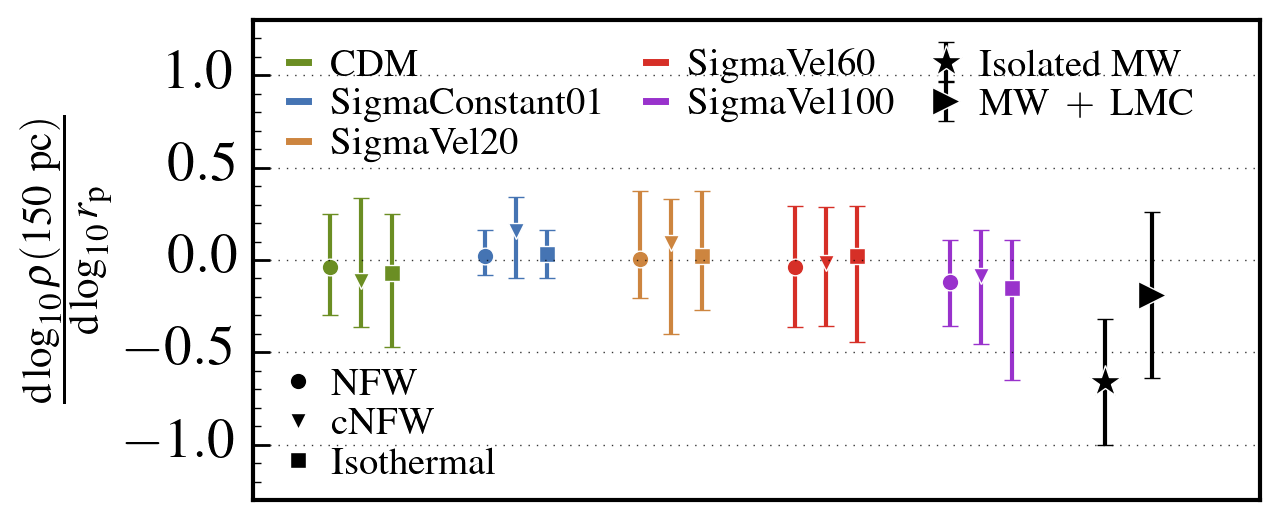

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3), dpi=200)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q_nfw, q_core_nfw, q_iso = [], [], []
    m_nfw, m_core_nfw, m_iso = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150_nfw, rho150_core_nfw, rho150_iso, M200 = [], [], [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']

                    # Get pericenter
                    _rp = data_subhalo["tree_data"]["pericenter"][1]
                    _rp = _rp[0] if _rp.shape==(1,) else _rp
                    rp = np.append(rp, _rp)

                    # Get NFW profile
                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                    rho150_nfw = np.append(rho150_nfw, _rho_150[0])
                    
                    # Get core-NFW profile
                    core_nfw_fit = data_subhalo['halo_data']['core_nfw_fit']
                    log10_M_200, r_c, n, sigma_log10_M200, sigma_r_c, sigma_n = core_nfw_fit
                    _rho_150 = 10**fit_core_nfw_model(np.array([0.15]), log10_M_200, r_c, n)
                    rho150_core_nfw = np.append(rho150_core_nfw, _rho_150[0])
                    
                    # Get ISO profile
                    iso_fit = data_subhalo['halo_data']['iso_fit'][:]
                    r_0, log10_rho_0, sigma_r_0, sigma_log10_rho_0 = iso_fit
                    _rho_150 = 10**fit_isothermal_model(np.array([0.15, 0.15]), r_0, log10_rho_0)
                    rho150_iso = np.append(rho150_iso, _rho_150[0])
                    
                    counter+=1
            
            if counter<8
            : continue# Fit only systems with at least 8 satellites
            # Fit NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_nfw)
            q_nfw = np.append(q_nfw, _q)
            m_nfw = np.append(m_nfw, _m)
            
            # Fit core-NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_core_nfw)
            q_core_nfw = np.append(q_core_nfw, _q)
            m_core_nfw = np.append(m_core_nfw, _m)
            
            # Fit ISO
            _q, _m = run_best_fit_for_sim(rp, rho150_iso)
            q_iso = np.append(q_iso, _q)
            m_iso = np.append(m_iso, _m)

    if id_name == "CDM":
        m_cdm_nfw = m_nfw.copy()
    if id_name == "SigmaVel100":
        m_sidm_nfw = m_nfw.copy()
        m_sidm_iso = m_iso.copy()


    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_nfw) - np.percentile(m_nfw,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_nfw)
    plt.errorbar(np.array([i]), np.array(np.median(m_nfw)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} NFW: {np.median(m_nfw)}")
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_core_nfw) - np.percentile(m_core_nfw,16)
    merr[1,0]= np.percentile(m_core_nfw,84) - np.median(m_core_nfw)
    plt.errorbar(np.array([i])+0.2, np.array(np.median(m_core_nfw)), yerr=merr, marker='v', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} cNFW: {np.median(m_core_nfw)}")
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_iso) - np.percentile(m_iso,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_iso)
    plt.errorbar(np.array([i])+0.4, np.array(np.median(m_iso)), yerr=merr, marker='s', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} ISO: {np.median(m_iso)}")
    
    plt.plot([], [], color=color_list[i], lw=2.5, label=fr'$\mathrm{{{id_name}}}$')

    ####
    file.close()

plt.grid('True')
plt.errorbar(np.array([i+1]), np.array(-0.66), yerr=np.ones((2, 1))*0.34, marker='*', markersize=12, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{Isolated\ MW}$', color='black')
plt.errorbar(np.array([i+1.3]), np.array(-0.19), yerr=np.ones((2, 1))*0.45, marker='>', markersize=10, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{MW\ +\ LMC}$', color='black')
plt.xticks([])
plt.xlim([-0.5, 6])
plt.ylim([-1.3, 1.3])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho(150\ \mathrm{pc})}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')

ax.legend(loc=[0.02,0.67], labelspacing=0.1, handlelength=0.5, handletextpad=0.6, frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)

ax2 = ax.twinx()
ax2.axis('off')
ax2.errorbar([], [], yerr=[], marker='o', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{NFW}$')
ax2.errorbar([], [], yerr=[], marker='v', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{cNFW}$')
ax2.errorbar([], [], yerr=[], marker='s', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{Isothermal}$')
ax2.legend(loc=[0.02,0.005], ncol=1, labelspacing=0.1, handlelength=0.5, handletextpad=0.6, 
           edgecolor='white', frameon=False, facecolor='goldenrod', framealpha=0.3, fontsize=14, columnspacing=1, numpoints=1)

####
plt.show()

In [67]:
# Num systems with m < -0.66 +/- 0.34
# Probability of within 1sigma for anti-correlation?
print('CDM')
num_CDM = len(np.where(m_cdm_nfw < -0.66+0.34)[0])
print(num_CDM/len(m_cdm_nfw))

print('SIDM')
# num_SigmaVel100 = len(np.where(m_sidm_nfw < -0.66+0.34)[0])
# print(num_SigmaVel100/len(m_sidm_nfw))
num_SigmaVel100 = len(np.where(m_sidm_iso < -0.66+0.34)[0])
print(num_SigmaVel100/len(m_sidm_iso))

# There is 16% probability for anti-correlation in CDM
# There is 36% probability for anti-correlation in SIDM
print('===')

# Probability of within 1sigma for no-correlation?
print('CDM')
num_CDM = len(np.where(m_cdm_nfw > -0.19-0.45)[0])
print(num_CDM/len(m_cdm_nfw))

print('SIDM')
# num_SigmaVel100 = len(np.where(m_sidm_nfw > -0.19-0.45)[0])
# print(num_SigmaVel100/len(m_sidm_nfw))
num_SigmaVel100 = len(np.where(m_sidm_iso > -0.19-0.45)[0])
print(num_SigmaVel100/len(m_sidm_iso))

# There is 100% probability for no-correlation in CDM
# There is 80% probability for no-correlation in SIDM


CDM
0.16
SIDM
0.36
===
CDM
1.0
SIDM
0.8


In [56]:
for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    rs_coefficient = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rho150_nfw, M = [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']

                    # Get NFW profile
                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                    rho150_nfw = np.append(rho150_nfw, _rho_150[0])

                    # Get mass
                    z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']
                    mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]
                    
                    M = np.append(M, mass_peak)
                    
                    counter+=1
            
            if counter<8: continue # Fit only systems with at least 8 satellites
            spearman_sim = stats.spearmanr(np.log10(M), np.log10(rho150_nfw))
            rs_coefficient = np.append(rs_coefficient, np.abs(spearman_sim[0]))
    
    if id_name == "CDM":
        rs_cdm = rs_coefficient.copy()
    if id_name == "SigmaVel100":
        rs_sidm = rs_coefficient.copy()


In [77]:
# Probability of moderate-to-strong correlation (rs>0.5)
print((rs_cdm>0.5).sum()/len(rs_cdm))
print((rs_sidm>0.5).sum()/len(rs_sidm))

# 76% of correlation in rho-Mhalo plane CDM
# 28% of correlatioon in rho-Mhalo plane SIDM

0.76
0.28


In [64]:
# Summary
# Joint probability of two independent events?: Anti-correlation (rho-rp) and correlation (rho-Mhalo)
# CDM: 0.16 * 0.76 = 0.12
# SIDM: 0.36 * 0.28 = 0.10

# Joint probability of two independent events?: Anti-correlation (rho-rp) and no-correlation (rho-Mhalo)
# CDM: 0.16 * (1-0.76) = 0.04
# SIDM: 0.36 * (1-0.28) = 0.26

# Joint probability of two independent events?: No-correlation (rho-rp) and correlation (rho-Mhalo)
# CDM: 1 * 0.76 = 0.76
# SIDM: 0.8 * 0.28 = 0.22

# Joint probability of two independent events?: No-correlation (rho-rp) and no-correlation (rho-Mhalo)
# CDM: 1 * (1-0.76) = 0.24
# SIDM: 0.8 * (1-0.28) = 0.58